In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../../load_magic/dataframes.py
%run ../../load_magic/storage.py
s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
dir()

['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['In', 'Out', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'csv', 'example_iterrows', 'exit', 'filepath_regex', 'get_column_descriptions', 'get_ipython', 'get_max_rsquared_adj', 'get_page_tables', 'io', 'math', 'os', 'pd', 'pickle', 'plt', 'quit', 're', 's', 'sm', 'sns', 'stats', 'sys', 'url_regex']

In [3]:

states_stats_df = s.load_object('states_stats_df').sort_index()
states_stats_df.columns.tolist()

['White_Percent', 'Black_Percent', 'Hispanic_Percent', 'Asian_Percent', 'Native_Percent', 'Islander_Percent', 'Multi_Percent', 'Gini_Index', 'Effectiveness_Rank', 'Health_Care_Score', 'Education_Score', 'Economy_Score', 'Infrastructure_Score', 'Opportunity_Score', 'Fiscal_Stability_Score', 'Crime_Corrections_Score', 'Natural_Environment_Score', 'district_abbreviation', 'GDP_Rank', 'GDP_2018', 'GDP_Percent', 'State_Region', 'Homicide_Rate_2018', 'Homicide_Rate_2017', 'Homicide_Rate_2014', 'Homicide_Rate_2010', 'Homicide_Rate_2005', 'Homicide_Rate_2000', 'Homicide_Rate_1996', 'Guns_Rank', 'Guns_Per_Capita', 'Guns_Registered', 'Suicide_Rate_2017', 'Suicide_Deaths_2017', 'Suicide_Rate_2016', 'Suicide_Deaths_2016', 'Suicide_Rate_2015', 'Suicide_Deaths_2015', 'Suicide_Rate_2014', 'Suicide_Deaths_2014', 'Suicide_Rate_2005', 'Suicide_Deaths_2005', 'Total_Inhabitants_2010', 'Inhabitants_Per_Square_Mile_2010', 'Total_Murder_Deaths_2010', 'Total_Gun_Murder_Deaths_2010', 'Gun_Ownership_Percent_201


----
# Scrape the Data

In [4]:

try:
    us_humdities_df = s.load_object('us_humdities_df')
except:
    tables_url = 'https://www.forbes.com/sites/brianbrettschneider/2018/08/23/oh-the-humidity-why-is-alaska-the-most-humid-state'
    tables_list = get_page_tables(tables_url)

No pickle exists at D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_humdities_df.pickle - attempting to load as csv.
No csv exists at D:\Documents\Repositories\notebooks\covid19\saves\csv\us_humdities_df.csv - attempting to download from URL.
[(0, (51, 5))]


In [14]:

us_humdities_df = tables_list[0].copy()
#us_humdities_df.columns = us_humdities_df.iloc[0].tolist()
us_humdities_df.columns = ['State_Name', 'Average_RH', 'RH_Rank', 'Average_Dew_Point', 'Dew_Point_Rank']
idx_list = list(range(1, 51))
mask_series = us_humdities_df.index.isin(idx_list)
us_humdities_df = us_humdities_df[mask_series]
us_humdities_df.Average_RH = us_humdities_df.Average_RH.map(lambda x: float(str(x).split('%')[0]))
us_humdities_df.Average_Dew_Point = us_humdities_df.Average_Dew_Point.map(lambda x: (float(str(x).split('°')[0]) - 32) * 5/9)
for column_name in ['RH_Rank', 'Dew_Point_Rank']:
    us_humdities_df[column_name] = us_humdities_df[column_name].map(lambda x: int(x))
us_humdities_df.set_index('State_Name', drop=True, inplace=True)
us_humdities_df.sample(5)

,Average_RH,RH_Rank,Average_Dew_Point,Dew_Point_Rank
State_Name,,,,
Alaska,77.1,1,-3.055556,50
Virginia,68.7,34,8.500000,12
Alabama,71.6,12,12.222222,5
West Virginia,69.7,27,6.000000,21
Arizona,38.5,49,0.277778,42


In [15]:

states_stats_df = states_stats_df.merge(us_humdities_df, left_index=True, right_index=True, suffixes=('_stats', '_humidity'))

In [16]:

s.store_objects(us_humdities_df=us_humdities_df, states_stats_df=states_stats_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_humdities_df.pickle
Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\states_stats_df.pickle


# Real-World Application to US Data

### Setup

Load US state case data from CovidTracking.com

In [17]:

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_series = pd.read_csv(url,
                            usecols=['date', 'state', 'death'],
                            parse_dates=['date'],
                            index_col=['state', 'date'],
                            squeeze=True).sort_index()

In [18]:

us_deaths_df = states_series.groupby('state').max().to_frame()
us_deaths_df.columns = ['Cumulative_Deaths']
us_deaths_df.index.name = 'State_Abbreviation'
us_deaths_df.sample(5)

,Cumulative_Deaths
State_Abbreviation,
ND,31.0
CA,2504.0
AS,0.0
OH,1271.0
AR,87.0


In [19]:

columns_list = ['State_Abbreviation', 'Average_Dew_Point', 'Census_Population_2010']
us_humdities_df = states_stats_df[columns_list]
us_humdities_df.set_index('State_Abbreviation', drop=True, inplace=True)
us_humdities_df.sample(5)

,Average_Dew_Point,Census_Population_2010
State_Abbreviation,,
OH,5.555556,11536504
HI,18.444444,1360301
MS,13.111111,2967297
OK,8.222222,3751351
CO,-1.777778,5029196



----
# Merge the Data

In [20]:

merge_df = us_humdities_df.merge(us_deaths_df, left_index=True, right_index=True, suffixes=('_humidity', '_deaths'))
merge_df['Deaths_per_Capita'] = merge_df.apply(lambda row_series: row_series.Cumulative_Deaths/row_series.Census_Population_2010,
                                               axis='columns')
merge_df.sample(5)

,Average_Dew_Point,Census_Population_2010,Cumulative_Deaths,Deaths_per_Capita
State_Abbreviation,,,,
MA,4.388889,6547629,4552.0,0.000695
NE,3.277778,1826341,86.0,0.000047
NY,4.111111,19378102,20828.0,0.001075
CT,4.833333,3574097,2797.0,0.000783
WI,2.833333,5686986,374.0,0.000066


In [21]:

import numpy as np

merge_df['Log_Deaths_per_Capita'] = merge_df.Deaths_per_Capita.map(lambda x: np.log(x))


----
# Plot the Data

In [23]:

%run ../../load_magic/charts.py
inf_nan_mask = get_inf_nan_mask(merge_df.Average_Dew_Point.values, merge_df.Log_Deaths_per_Capita.values)
df = merge_df[pd.Series(inf_nan_mask, index=merge_df.index)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:417: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(grid, yhat, **kws)


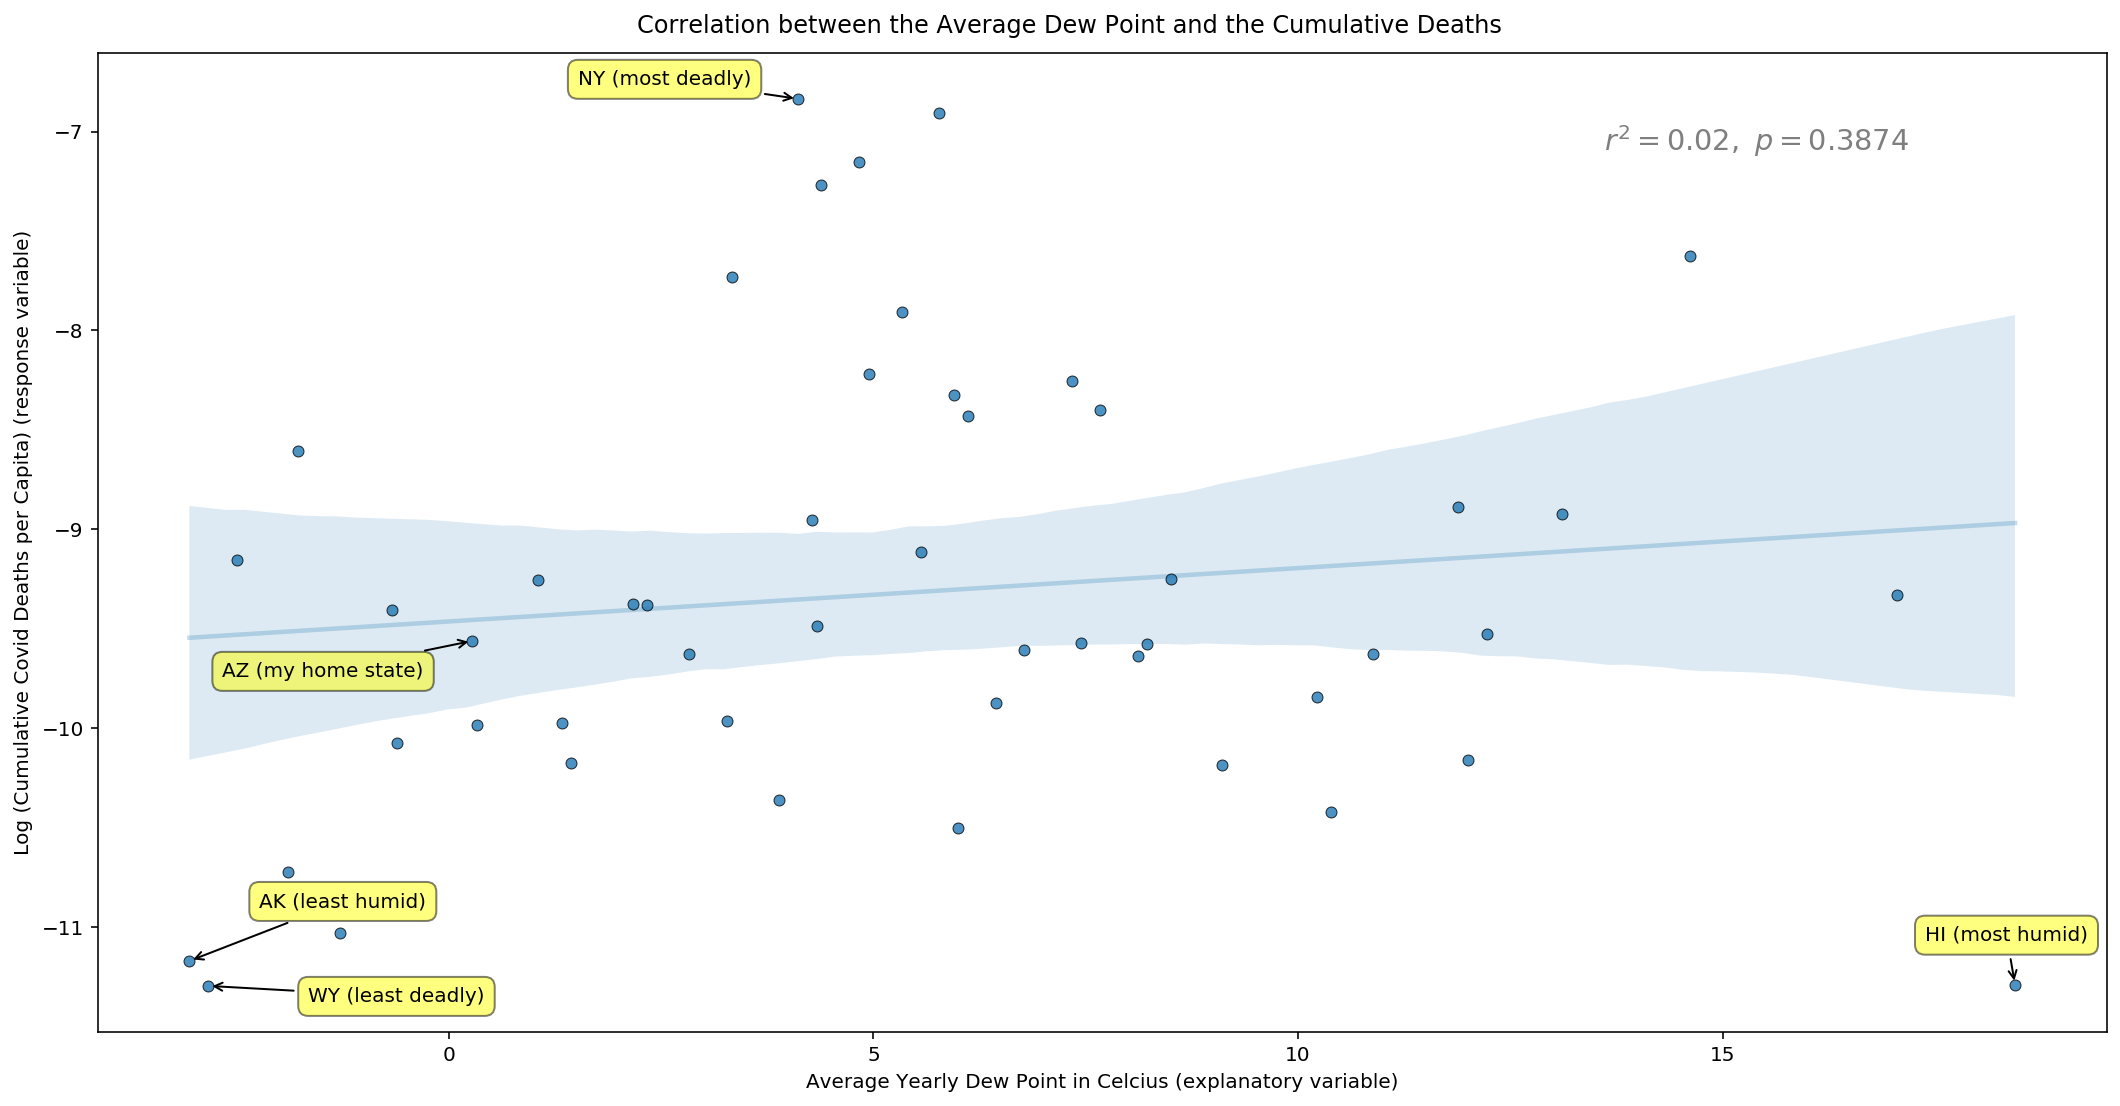

In [29]:

title_text = 'Correlation between the Average Dew Point and the Cumulative Deaths'
first_order_linear_scatterplot(df, 'Average_Dew_Point', 'Log_Deaths_per_Capita',
                               xlabel_str='Average Yearly Dew Point in Celcius (explanatory variable)',
                               ylabel_str='Log (Cumulative Covid Deaths per Capita) (response variable)',
                               x_adj='humid', y_adj='deadly', title=title_text, idx_reference='AZ',
                               annot_reference='my home state', aspect_ratio=18/9,
                               least_x_xytext=(35, 25), most_x_xytext=(-45, 20),
                               least_y_xytext=(50, -10), most_y_xytext=(-110, 5),
                               reference_xytext=(-125, -20))